In [38]:
import os; os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pandas as pd
import tensorflow_addons as tfa
import cv2
from perceptual_quality import nlpd
import tensorflow as tf
from tensorflow.keras.utils import get_file
from perceptnet.networks import PerceptNet
from pathlib import Path

from PIL import Image
from glob import glob

from pickle import dump, load
import scipy.interpolate as scp

import re


from perceptualtests.color_matrices import *
from scipy import interpolate
from sympy import Point, Line, Polygon, Circle, Ray
from scipy.io import loadmat

In [40]:
data = pd.DataFrame(pd.read_csv("TID13_Illuminant.csv"))
data = data.drop("Referencia", axis = 1)

met1 = pd.DataFrame(pd.read_csv("TID13_Iluminantes.csv"))
met2 = pd.DataFrame(pd.read_csv("TID13_Iluminantes_PIM.csv"))

In [41]:
referencias = []
tonos = []
saturaciones = []
for i  in range(len(data["Distorsion"])):
    ml,user, file,img, tono, sat = re.findall( "\d+",data["Distorsion"][i])
    referencias.append(img)
    tonos.append(tono)
    saturaciones.append(sat)

In [42]:
datos = pd.DataFrame()
datos["Referencia"] = referencias
datos["Tono"] = tonos
datos["Saturacion"] = saturaciones
datos["RMSE"] = met1["RMSE"]
datos["SSIM"] = met1["SSIM"]
datos["LPIPS"] = met1["LPIPS"]
datos["DISTS"] = met1["DISTS"]
datos["PerceptNet"] = met1["PerceptNet"]
datos["PIM"] = met2["PIM"]
datos["Distorsion"] = data["Distorsion"]

In [43]:
datos

,Referencia,Tono,Saturacion,RMSE,SSIM,LPIPS,DISTS,PerceptNet,PIM,Distorsion
0,23,2,1,0.005456,0.001270,0.001736,0.000814,0.001082,4.745815,/lustre/ific.uv.es/ml/uv075/Databases/Nuria_Pa...
1,23,5,7,0.035352,0.005938,0.014625,0.008542,0.006018,66.273390,/lustre/ific.uv.es/ml/uv075/Databases/Nuria_Pa...
2,23,12,5,0.050689,0.008413,0.024598,0.021028,0.006483,55.183617,/lustre/ific.uv.es/ml/uv075/Databases/Nuria_Pa...
3,23,10,6,0.073219,0.016005,0.054687,0.040168,0.006332,73.411110,/lustre/ific.uv.es/ml/uv075/Databases/Nuria_Pa...
4,23,1,5,0.052482,0.013200,0.043516,0.025128,0.005819,73.168755,/lustre/ific.uv.es/ml/uv075/Databases/Nuria_Pa...
...,...,...,...,...,...,...,...,...,...,...
3995,20,4,1,0.002603,0.000744,0.000761,0.000802,0.000903,0.181333,/lustre/ific.uv.es/ml/uv075/Databases/Nuria_Pa...
3996,20,10,6,0.039276,0.008326,0.018800,0.040394,0.004971,7.475205,/lustre/ific.uv.es/ml/uv075/Databases/Nuria_Pa...
3997,20,8,7,0.044295,0.011915,0.032574,0.047148,0.003438,18.623444,/lustre/ific.uv.es/ml/uv075/Databases/Nuria_Pa...
3998,20,8,8,0.050810,0.014459,0.039175,0.056674,0.003781,21.971277,/lustre/ific.uv.es/ml/uv075/Databases/Nuria_Pa...


In [44]:
def load_img(img):
    img = tf.io.read_file(img)
    img = tf.cast(tf.io.decode_png(img, channels=3), tf.float32)/255.
    return img

In [45]:
tono = np.arange(1,21,1)
saturacion = np.arange(1,9,1)
metrics = ["RMSE", "SSIM", "LPIPS", "DISTS", "PerceptNet", "PIM"]
result = {} 

for i in tono:
    for j in saturacion:
        result[(i, j)] = {"RMSE":[], "SSIM":[], "LPIPS":[], "DISTS":[], "PerceptNet":[]}
        for metric in metrics:
            media = np.mean(datos[(datos["Tono"] == str(i)) & (datos["Saturacion"] == str(j))][metric])
            result[(i, j)][metric] = media

In [46]:
df_results = pd.DataFrame(result).T
df_results = df_results.reset_index()
df_results = df_results.rename({"level_0": "Tono", "level_1": "Saturacion"}, axis=1)
df_results.head()

,Tono,Saturacion,RMSE,SSIM,LPIPS,DISTS,PerceptNet,PIM
0,1,1,0.006188,0.001123,0.002601,0.001579,0.001238,1.398126
1,1,2,0.013883,0.001824,0.005549,0.005290,0.001815,4.528031
2,1,3,0.021419,0.003831,0.010351,0.011087,0.003455,7.403559
3,1,4,0.028812,0.005848,0.017000,0.015471,0.003909,10.994932
4,1,5,0.037769,0.008497,0.025865,0.023094,0.005143,15.095747


In [47]:
extra = {
    "Tono": range(1,21),
    "Saturacion": [0]*20,
    "RMSE": [0]*20,
	"SSIM": [0]*20,
    "LPIPS": [0]*20,
    "DISTS": [0]*20,
    "PerceptNet": [0]*20,
    "PIM": [0]*20,
}
extra = pd.DataFrame(extra)

df_results = pd.concat([df_results, extra], axis=0)
df_results = df_results.sort_values(by=["Tono", "Saturacion"])
df_results


,Tono,Saturacion,RMSE,SSIM,LPIPS,DISTS,PerceptNet,PIM
0,1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,1,1,0.006188,0.001123,0.002601,0.001579,0.001238,1.398126
1,1,2,0.013883,0.001824,0.005549,0.005290,0.001815,4.528031
2,1,3,0.021419,0.003831,0.010351,0.011087,0.003455,7.403559
3,1,4,0.028812,0.005848,0.017000,0.015471,0.003909,10.994932
...,...,...,...,...,...,...,...,...
155,20,4,0.031575,0.006618,0.022635,0.018834,0.003836,14.092382
156,20,5,0.040256,0.009665,0.033814,0.026484,0.004732,18.566053
157,20,6,0.047458,0.012126,0.042730,0.032293,0.005191,22.343724
158,20,7,0.056419,0.016483,0.055979,0.040119,0.005978,27.325340


In [48]:
def pot(x, a, b):
    y = a * x**b
    return (y)

with open("fs_pot.pkl", "rb") as f:
    fs = load(f)

# Umbrales y elipses

In [49]:
def satur_intersections(metrics, umbrales, plot=False):

    tono = np.arange(1,21,1)
  

    list_RMSE = []
    list_SSIM = []
    list_LPIPS = []
    list_DISTS = []
    list_PerceptNet= []
    list_PIM = []



    if plot: fig, ax = plt.subplots(20,6, figsize=(25,20), sharex=True, sharey=True)

    for i in tono:
        for j, metric in enumerate(metrics):
            data = df_results[(df_results["Tono"] == i)]
            if plot:
                if i == 1:
                    ax[i-1,j].set_title(metric)
                if j == 0:
                    ax[i-1,j].set_ylabel("Tono = " + str(i))

            if metric == "RMSE":
                if plot: ax[i-1,j].plot(data["Saturacion"], pot(data[metric], *fs[0]))
                interpol = scp.interp1d(pot(data[metric], *fs[0]), data["Saturacion"],  bounds_error=False)

                interpols = interpol(umbrales)
                list_RMSE.append(interpols)

                if plot:
                    ax[i-1,j].axvline(interpols, color = "pink")
                    ax[i-1,j].axhline(umbrales, color = "pink")

            elif metric == "SSIM":
                if plot: ax[i-1,j].plot(data["Saturacion"], pot(data[metric], *fs[1]))
                interpol = scp.interp1d(pot(data[metric], *fs[1]), data["Saturacion"],  bounds_error=False)

                interpols = interpol(umbrales)
                list_SSIM.append(interpols)
                
                if plot:
                    ax[i-1,j].axvline(interpols, color = "pink")
                    ax[i-1,j].axhline(umbrales, color = "pink")

            elif metric == "LPIPS":
                if plot: ax[i-1,j].plot(data["Saturacion"], pot(data[metric], *fs[2]))
                interpol = scp.interp1d(pot(data[metric], *fs[2]), data["Saturacion"],  bounds_error=False)

                interpols = interpol(umbrales)
                list_LPIPS.append(interpols)
                
                if plot:
                    ax[i-1,j].axvline(interpols, color = "pink")
                    ax[i-1,j].axhline(umbrales, color = "pink")

            elif metric == "DISTS":
                if plot: ax[i-1,j].plot(data["Saturacion"], pot(data[metric], *fs[3]))
                interpol = scp.interp1d(pot(data[metric], *fs[3]), data["Saturacion"],  bounds_error=False)

                interpols = interpol(umbrales)
                list_DISTS.append(interpols)
                
                if plot:
                    ax[i-1,j].axvline(interpols, color = "pink")
                    ax[i-1,j].axhline(umbrales, color = "pink")

            elif metric == "PerceptNet":
                if plot: ax[i-1,j].plot(data["Saturacion"], pot(data[metric], *fs[4]))
                interpol = scp.interp1d(pot(data[metric], *fs[4]), data["Saturacion"],  bounds_error=False)

                interpols = interpol(umbrales)
                list_PerceptNet.append(interpols)
                
                if plot:
                    ax[i-1,j].axvline(interpols, color = "pink")
                    ax[i-1,j].axhline(umbrales, color = "pink")

            elif metric == "PIM":
                if plot: ax[i-1,j].plot(data["Saturacion"], pot(data[metric], *fs[5]))
                interpol = scp.interp1d(pot(data[metric], *fs[5]), data["Saturacion"],  bounds_error=False)

                interpols = interpol(umbrales)
                list_PIM.append(interpols)

                if plot:
                    ax[i-1,j].axvline(interpols, color = "pink")
                    ax[i-1,j].axhline(umbrales, color = "pink")

    return [list_RMSE, list_SSIM,list_LPIPS, list_DISTS, list_PerceptNet,list_PIM]

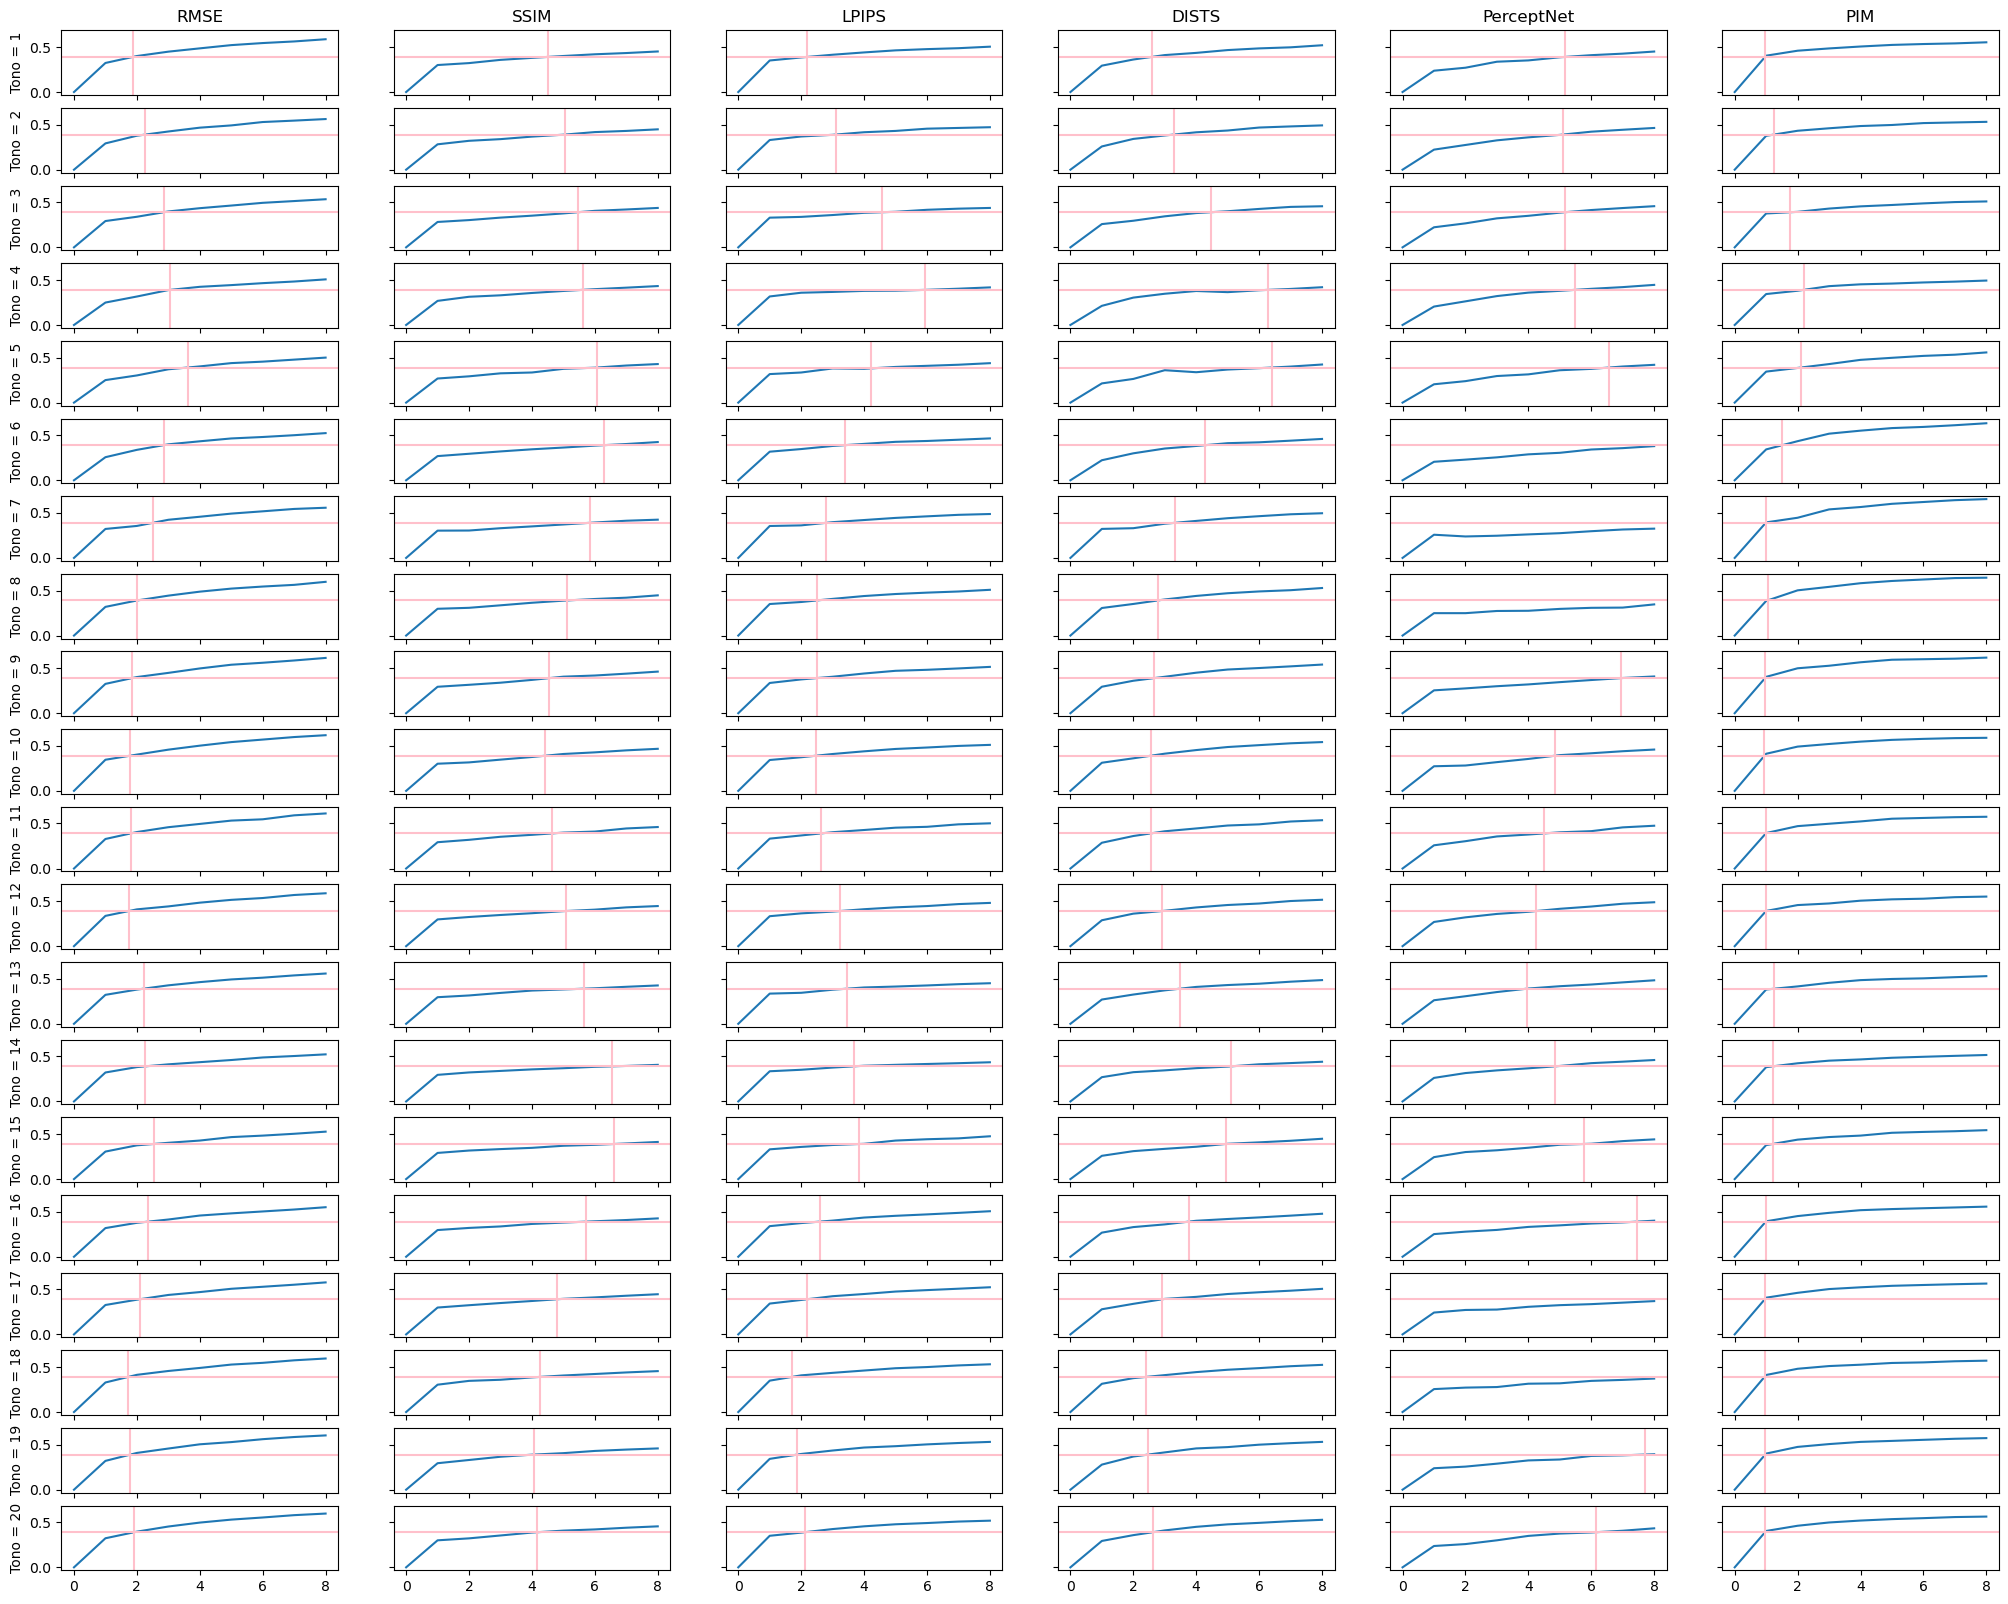

In [50]:
listas_40 = satur_intersections(["RMSE", "SSIM", "LPIPS", "DISTS", "PerceptNet", "PIM"], 0.390, plot = True)
listas_44 = satur_intersections(["RMSE", "SSIM", "LPIPS", "DISTS", "PerceptNet", "PIM"], 0.445)
listas_49 = satur_intersections(["RMSE", "SSIM", "LPIPS", "DISTS", "PerceptNet", "PIM"], 0.499)

In [51]:
interseccion_experimental = [np.array(1.95536),
 np.array(np.nan),
 np.array(2.64413),
 np.array(2.7789),
 np.array(2.64413),
 np.array(1.95536),
 np.array(np.nan),
 np.array(1.383),
 np.array(np.nan),
 np.array(np.nan),
 np.array(1.95536),
 np.array(np.nan),
 np.array(2.64413),
 np.array(2.7789),
 np.array(2.64413),
 np.array(1.95536),
 np.array(np.nan),
 np.array(1.383),
 np.array(np.nan),
 np.array(np.nan)]

#### Cosas del Locus

In [52]:
triangulo = loadmat("std_crt.mat")
macadam = loadmat("macadam.mat")
mac = macadam["T"]

mac2 = []
for i in range(0,2500):
    mac2.append(mac[i]/mac[i].sum())
mac2 = pd.DataFrame(mac2)

t_lambda = T_lambda.copy()
t_lambda[:,1:] = T_lambda[:,1:]/T_lambda[:,1:].sum(axis=1)[:,None]

locus = Polygon(*[Point(x,y) for x, y in zip(t_lambda[:,1], t_lambda[:,2])])

In [53]:
def get_opposite_lambda(l: Point, # Lambda of which we want to calculate the opposite.
                        locus: Polygon, # Locus being used.
                        ) -> Point: # Opposite lambda.
    """Returns the opposite of a given lambda in a given locus."""
    white = Point(1/3, 1/3)
    l_line = Line(l, white)
    intersection_line_locus = l_line.intersection(locus)
    idx_max = np.argmax([l.distance(intersection_point) for intersection_point in intersection_line_locus])
    l_op = intersection_line_locus[idx_max]
    return l_op

In [54]:
def lambda2t_(l, # Lambda to transform into t coordinates.
             return_point=False, # Wether to return a Point object or an np.ndarray.
             ): # Three component vector in t coordinates.
    """Gives the t coordinates of a specific lambda."""
    t1 = interpolate.interp1d(t_lambda[:,0], t_lambda[:,1])
    t2 = interpolate.interp1d(t_lambda[:,0], t_lambda[:,2])
    t1_lambda = t1(l)
    t2_lambda = t2(l)
    t3_lambda = 1 - t1_lambda - t2_lambda
    lambda_t = np.array([t1_lambda, t2_lambda, t3_lambda])
    if return_point: lambda_t = Point(*lambda_t[:-1])
    return lambda_t

In [55]:
def lambda2t(l, return_point=True):
    if l < 0:
        l = lambda2t_(-l, return_point=return_point)
        l = get_opposite_lambda(l, locus)
    else:
        l = lambda2t_(l, return_point=return_point)
    return l

In [56]:
def adjust_points(point):
    return point*(0.3733-1/3)/8

In [57]:
O = np.array((1/3, 1/3))
radios = np.array([0.33633, 0.341616, 0.346901, 0.352187, 0.357473, 0.362759, 0.368044, 0.37333]) - O[0]
radios

array([0.00299667, 0.00828267, 0.01356767, 0.01885367, 0.02413967,
       0.02942567, 0.03471067, 0.03999667])

In [58]:
tonos = [611,591,582,574,565,554,533,510,501,495,491,486,481,467,-565,-554,-533,-510,-501,-495]
tonos_tt = np.stack([np.array(lambda2t(t, return_point=True)).astype(np.float32) for t in tonos])
tonos_tt.shape

(20, 2)

In [59]:
def get_intersection(line, circle):
    try:
        return np.array(line.intersection(circle)[0]).astype(np.float32)
    except:
        return None

In [60]:
def definitive_intersection(listas):
    intersections = []
    for lista in listas:
        df = pd.DataFrame(dict(
            r=lista,
            theta=["Tono 1", "Tono 2", "Tono 3", "Tono 4", "Tono 5", "Tono 6", "Tono 7", "Tono 8", "Tono 9", "Tono 10", "Tono 11",
                    "Tono 12", "Tono 13", "Tono 14", "Tono 15", "Tono 16", "Tono 17", "Tono 18", "Tono 19", "Tono 20" ]))
        df["r_adj"] = df["r"].apply(adjust_points)
        
        circles = [Circle(O, r) for r in df.r_adj]
        lines = [Ray(O, p) for p in tonos_tt]
        intersection = [get_intersection(l, c) for l, c in zip(lines, circles)]
        intersections.append(intersection)
    return intersections

In [61]:
intersections_40 = definitive_intersection(listas_40)
intersections_44 = definitive_intersection(listas_44)
intersections_49 = definitive_intersection(listas_49)
intersecciones_experimental = definitive_intersection([interseccion_experimental])[0]


### Movidas de elipses

In [62]:
def fit_ellipse(x, y):
    """

    Fit the coefficients a,b,c,d,e,f, representing an ellipse described by
    the formula F(x,y) = ax^2 + bxy + cy^2 + dx + ey + f = 0 to the provided
    arrays of data points x=[x1, x2, ..., xn] and y=[y1, y2, ..., yn].

    Based on the algorithm of Halir and Flusser, "Numerically stable direct
    least squares fitting of ellipses'.


    """

    D1 = np.vstack([x**2, x*y, y**2]).T
    D2 = np.vstack([x, y, np.ones(len(x))]).T
    S1 = D1.T @ D1
    S2 = D1.T @ D2
    S3 = D2.T @ D2
    T = -np.linalg.inv(S3) @ S2.T
    M = S1 + S2 @ T
    C = np.array(((0, 0, 2), (0, -1, 0), (2, 0, 0)), dtype=float)
    M = np.linalg.inv(C) @ M
    eigval, eigvec = np.linalg.eig(M)
    con = 4 * eigvec[0]* eigvec[2] - eigvec[1]**2
    ak = eigvec[:, np.nonzero(con > 0)[0]]
    return np.concatenate((ak, T @ ak)).ravel()


def cart_to_pol(coeffs):
    """

    Convert the cartesian conic coefficients, (a, b, c, d, e, f), to the
    ellipse parameters, where F(x, y) = ax^2 + bxy + cy^2 + dx + ey + f = 0.
    The returned parameters are x0, y0, ap, bp, e, phi, where (x0, y0) is the
    ellipse centre; (ap, bp) are the semi-major and semi-minor axes,
    respectively; e is the eccentricity; and phi is the rotation of the semi-
    major axis from the x-axis.

    """

    # We use the formulas from https://mathworld.wolfram.com/Ellipse.html
    # which assumes a cartesian form ax^2 + 2bxy + cy^2 + 2dx + 2fy + g = 0.
    # Therefore, rename and scale b, d and f appropriately.
    a = coeffs[0]
    b = coeffs[1] / 2
    c = coeffs[2]
    d = coeffs[3] / 2
    f = coeffs[4] / 2
    g = coeffs[5]

    den = b**2 - a*c
    if den > 0:
        raise ValueError('coeffs do not represent an ellipse: b^2 - 4ac must'
                         ' be negative!')

    # The location of the ellipse centre.
    x0, y0 = (c*d - b*f) / den, (a*f - b*d) / den

    num = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
    fac = np.sqrt((a - c)**2 + 4*b**2)
    # The semi-major and semi-minor axis lengths (these are not sorted).
    ap = np.sqrt(num / den / (fac - a - c))
    bp = np.sqrt(num / den / (-fac - a - c))

    # Sort the semi-major and semi-minor axis lengths but keep track of
    # the original relative magnitudes of width and height.
    width_gt_height = True
    if ap < bp:
        width_gt_height = False
        ap, bp = bp, ap

    # The eccentricity.
    r = (bp/ap)**2
    if r > 1:
        r = 1/r
    e = np.sqrt(1 - r)

    # The angle of anticlockwise rotation of the major-axis from x-axis.
    if b == 0:
        phi = 0 if a < c else np.pi/2
    else:
        phi = np.arctan((2.*b) / (a - c)) / 2
        if a > c:
            phi += np.pi/2
    if not width_gt_height:
        # Ensure that phi is the angle to rotate to the semi-major axis.
        phi += np.pi/2
    phi = phi % np.pi

    return x0, y0, ap, bp, e, phi


def get_ellipse_pts(params, npts=100, tmin=0, tmax=2*np.pi):
    """
    Return npts points on the ellipse described by the params = x0, y0, ap,
    bp, e, phi for values of the parametric variable t between tmin and tmax.

    """

    x0, y0, ap, bp, e, phi = params
    # A grid of the parametric variable, t.
    t = np.linspace(tmin, tmax, npts)
    x = x0 + ap * np.cos(t) * np.cos(phi) - bp * np.sin(t) * np.sin(phi)
    y = y0 + ap * np.cos(t) * np.sin(phi) + bp * np.sin(t) * np.cos(phi)
    return x, y


### Ajuste de elipses

In [63]:
def get_ellipse(lista):
    a = [a for a in lista if a is not None]
    a = np.stack(a, axis=0)
    coeffs = fit_ellipse(a[:,0], a[:,1])
    x0, y0, ap, bp, e, phi = cart_to_pol(coeffs)
    x, y = get_ellipse_pts((x0, y0, ap, bp, e, phi))
    return x, y

In [64]:
coeffs_ = [cart_to_pol(fit_ellipse(mac2[0][i:i+100], mac2[1][i:i+100])) for i in [1200, 1300, 1900]]
coeffs_a = np.array(coeffs_)
coeffs_m = coeffs_a.mean(axis=0)
coeffs_a.shape, coeffs_m.shape
x_m, y_m = get_ellipse_pts((0.333333,0.3333333, *coeffs_m[2:]))

In [65]:
x_exp, y_exp = get_ellipse(intersecciones_experimental)

In [72]:
dif_mac = {}
dif_exp = {}

for name,l_44 in zip(names, intersections_44):

    x_elip_44, y_elip_44 = get_ellipse(l_44)
    difs_44 = np.sqrt(np.mean((x_m-x_elip_44)**2 + (y_m-y_elip_44)**2))
    dif_mac[name] = difs_44

    difs_exp44 = np.sqrt(np.mean((x_exp-x_elip_44)**2 + (y_exp-y_elip_44)**2))
    dif_exp[name] = difs_exp44


In [73]:
def plot_locus(intersecc,listas , names, dif_mac = [], dif_exp=[]):    
    
    for inter,lista,name in zip(intersecc,listas,names):
        df = pd.DataFrame(dict(
        r=inter,
        theta=["Tono 1", "Tono 2", "Tono 3", "Tono 4", "Tono 5", "Tono 6", "Tono 7", "Tono 8", "Tono 9", "Tono 10", "Tono 11",
                "Tono 12", "Tono 13", "Tono 14", "Tono 15", "Tono 16", "Tono 17", "Tono 18", "Tono 19", "Tono 20" ]))
        df["r_adj"] = df["r"].apply(adjust_points)

        circles = [Circle(O, r) for r in df["r_adj"]]
        lines = [Ray(O, p) for p in tonos_tt]

        t_lambda = T_lambda.copy()
        t_lambda[:,1:] = T_lambda[:,1:]/T_lambda[:,1:].sum(axis=1)[:,None]

        plt.figure()
        plt.plot(t_lambda[:,1], t_lambda[:,2], '--b')
        plt.plot([t_lambda[0,1], t_lambda[-1,1]], [t_lambda[0,2], t_lambda[-1,2]], '--b')

        if name == "RMSE":
            for l in range(20):
                plt.plot((lines[l].points[0].x, lines[l].points[1].x), (lines[l].points[0].y,lines[l].points[1].y), "-", linewidth = 1, color = "gray")
            plt.plot(x_exp,y_exp, color = "firebrick", label = "Experimental Ellipse")
            plt.plot(x_m,y_m, color = "darkorchid", label = "Interpolated MacAdam Ellipse")

            for i in [1200, 1300, 1900]:
                if i == 1200:
                    plt.plot(mac2[0][i:i+100], mac2[1][i:i+100], c = "green", label = "Original MacAdam Ellipses")
                else:
                    plt.plot(mac2[0][i:i+100], mac2[1][i:i+100], c = "green")
            plt.legend(loc = 'lower right')

        plt.plot((triangulo["chro_guns"][:,9][1],triangulo["chro_guns"][:,9][3],triangulo["chro_guns"][:,9][5],triangulo["chro_guns"][:,9][1]), 
                (triangulo["chro_guns"][:,9][2],triangulo["chro_guns"][:,9][4],triangulo["chro_guns"][:,9][6],triangulo["chro_guns"][:,9][2]), "-.",linewidth=1)

        # for kkk in tonos_tt:
        #     plt.plot(*kkk, 'or',markersize = 1.5)

        for kkk in lista:
            try:
                plt.plot(*kkk, '.r',markersize = 1.5)
            except:
                continue
        
        for i in [1200, 1300, 1900]:
            if i == 1200:
                plt.plot(mac2[0][i:i+100], mac2[1][i:i+100], c = "green")
            else:
                plt.plot(mac2[0][i:i+100], mac2[1][i:i+100], c = "green")


        x, y = get_ellipse(lista)
        plt.plot(x,y, color = "red")

        plt.plot(x_exp,y_exp, color = "firebrick", label = "Experimental Ellipse")
        plt.plot(x_m,y_m, color = "darkorchid", label = "Interpolated MacAdam Ellipse")

        if name == "RMSE" or name == "DISTS":
            plt.ylabel("y")
        else:
            plt.ylabel(" ")

        if name == "DISTS" or name == "PerceptNet" or name == "PIM":
            plt.xlabel("x")
        else: 
            plt.xlabel(" ")
          

        plt.xlim([0.2, 0.5])
        plt.ylim([0.2, 0.5])
        plt.title(f"{name}. Error: {dif_mac[name]:.3f} | {dif_exp[name]:.3f}")
        plt.savefig(f"Ilu_TID_{name}.png", dpi=300,bbox_inches = "tight")


        plt.show()
        # break
        

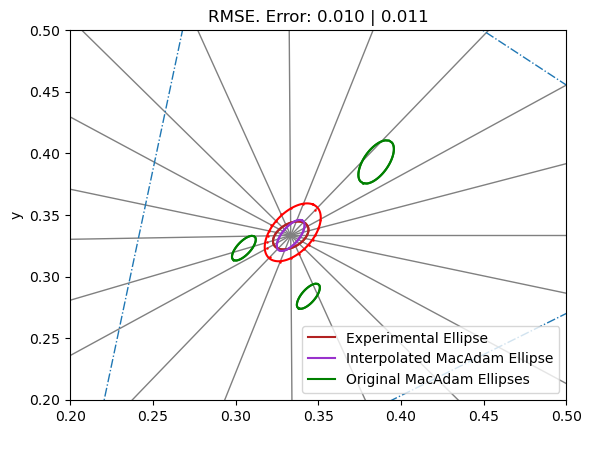

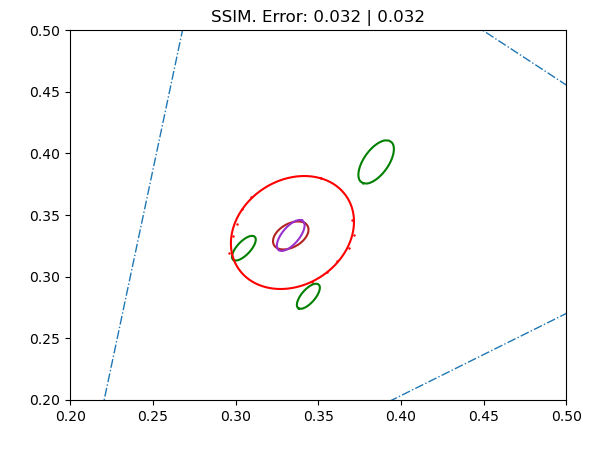

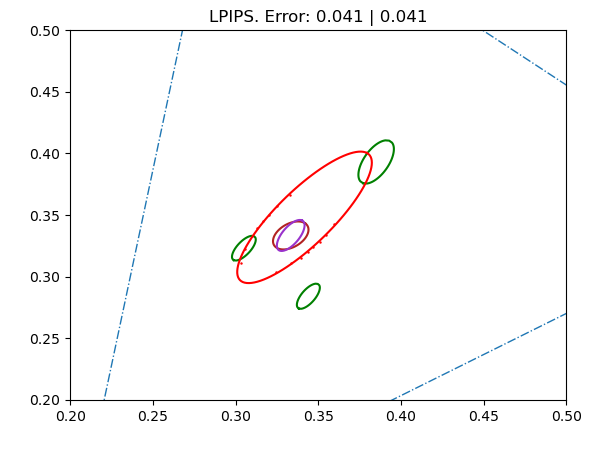

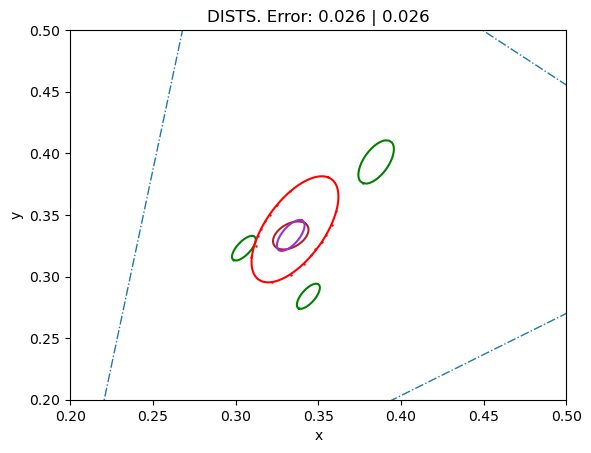

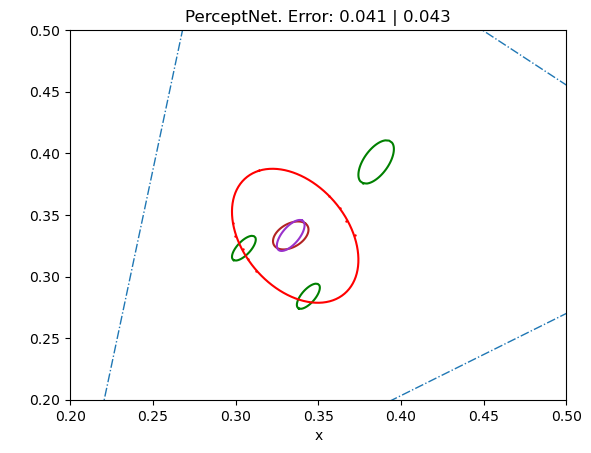

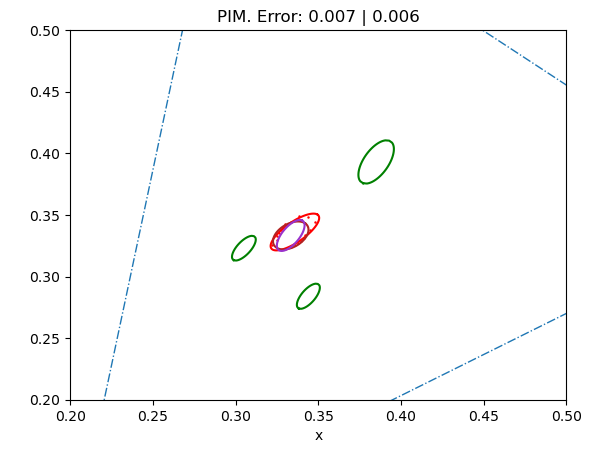

In [74]:
plot_locus(intersecc = listas_44,listas = [*intersections_44, intersecciones_experimental],names=["RMSE", "SSIM", "LPIPS", "DISTS", "PerceptNet", "PIM", "Experimental"], dif_mac = dif_mac, dif_exp=dif_exp)